In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import numpy as np
from sourcesep.models.nmf_variants import set_norm

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'


def gaussfn(x, mu, sig): return 1/(np.sqrt(2*np.pi)*sig) * \
    np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

a_col = gaussfn(np.arange(200), mu=20, sig=10)
b_col = gaussfn(np.arange(200), mu=40, sig=10)
c_col = gaussfn(np.arange(200), mu=80, sig=10)

a_coef_ = [1.0, 0.0, 0.0]
a_col_ = np.concatenate([a_coef_[0] * a_col, a_coef_[1]*a_col, a_coef_[2]*a_col])
a_col_ = set_norm(a_col_.reshape(-1,1), axis=0, c=1)[0]

b_coef_ = [0.0, 1.0, 0.0]
b_col_ = np.concatenate([b_coef_[0] * b_col, b_coef_[1]*b_col, b_coef_[2]*b_col])
b_col_ = set_norm(b_col_.reshape(-1,1), axis=0, c=1)[0]

c_coef_ = [0.0, 0.0, 1.0]
c_col_ = np.concatenate([c_coef_[0] * c_col, c_coef_[1]*c_col, c_coef_[2]*c_col])
c_col_ = set_norm(c_col_.reshape(-1,1), axis=0, c=1)[0]

A = np.concatenate([a_col_,b_col_,c_col_], axis=1)

h_init_ab = 0.5 * np.abs(np.random.rand(1, 100)) 
h_init_ab = h_init_ab.reshape(1,-1)
h_init_c = 0.5 * np.abs(np.random.rand(1, 100))
H = np.concatenate([1.0+h_init_ab,1.0-h_init_ab,1+h_init_c], axis=0)
H = set_norm(H, axis=1, c=1)[0]
X = A@H

print(f'A {A.shape}')
print(f'H {H.shape}')
print(f'X {X.shape}')

A (600, 3)
H (3, 100)
X (600, 100)


In [2]:
np.mean(H,axis=1)

array([0.0993506 , 0.09826006, 0.09937504])

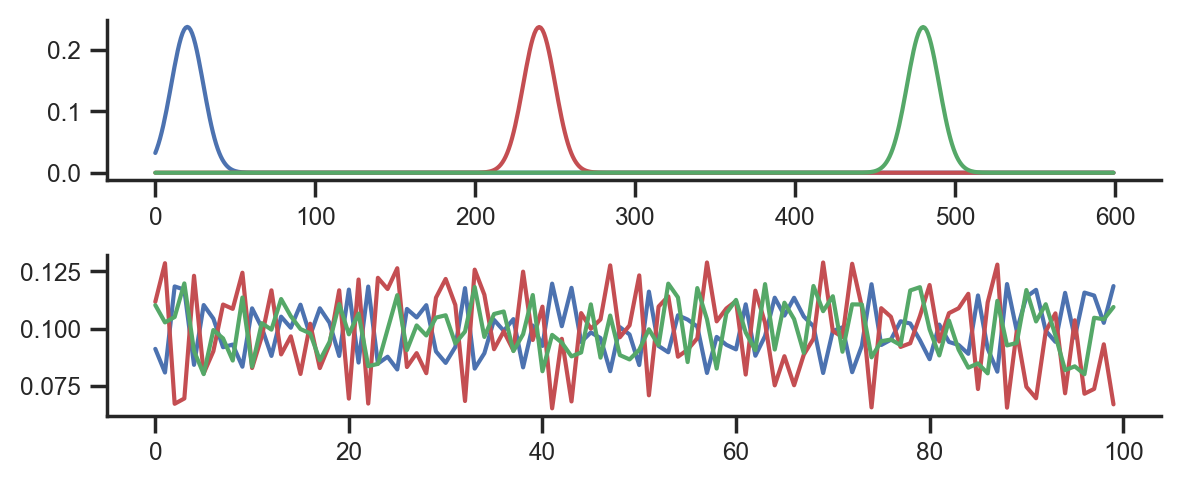

In [3]:
f, ax = plt.subplots(2, 1, figsize=(6,2.5))
ax[0].plot(A[:, 0], c='b')
ax[0].plot(A[:, 1], c='r')
ax[0].plot(A[:, 2], c='g')

ax[1].plot(H[0, :], c='b')
ax[1].plot(H[1, :], c='r')
ax[1].plot(H[2, :], c='g')
plt.tight_layout()
plt.show()

In [4]:
a_coef = torch.tensor([1.0, 0.5, 1.0], requires_grad=True, dtype=torch.float32)
b_coef = torch.tensor([0.5, 2.0, 0.5], requires_grad=True, dtype=torch.float32)
c_coef = torch.tensor([1.0, 1.0, 1.0], requires_grad=True, dtype=torch.float32)

a_init = torch.tensor(np.abs(a_col + np.random.randn(200)*0.01), requires_grad=True, dtype=torch.float32)
b_init = torch.tensor(np.abs(b_col + np.random.randn(200)*0.01), requires_grad=True, dtype=torch.float32)
c_init = torch.tensor(np.abs(c_col + np.random.randn(200)*0.01), requires_grad=True, dtype=torch.float32)

h_coef = torch.tensor([.1, .1, .1], requires_grad=True, dtype=torch.float32)
h_bias = torch.tensor([.1, .1, .1], requires_grad=True, dtype=torch.float32)

h_init_ab = torch.tensor(0.1*np.abs(np.random.rand(1, 100)), requires_grad=True, dtype=torch.float32)
h_init_c = torch.tensor(0.1*np.abs(np.random.rand(1, 100)) , requires_grad=True, dtype=torch.float32)

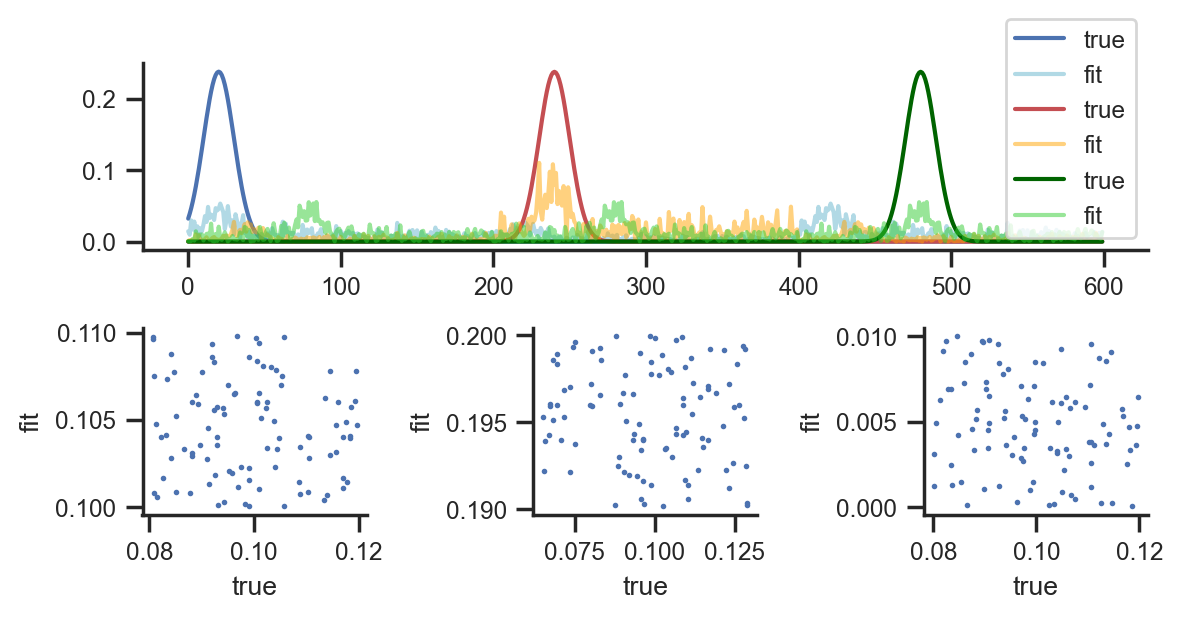

Loss: 1.4057352542877197


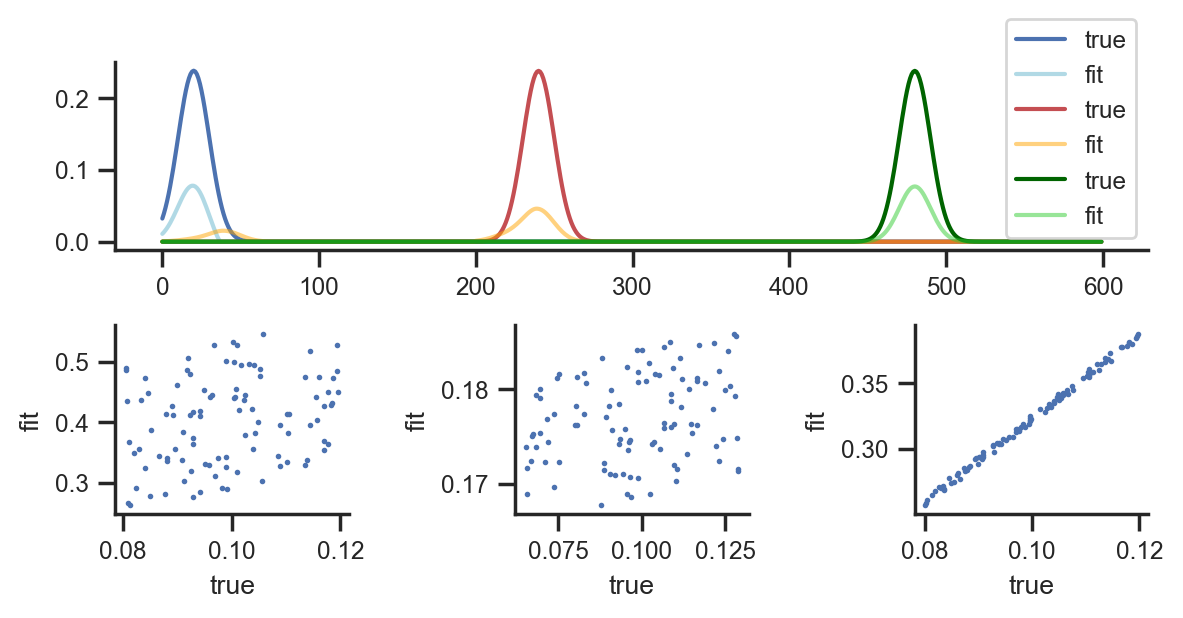

Loss: 0.7742462754249573


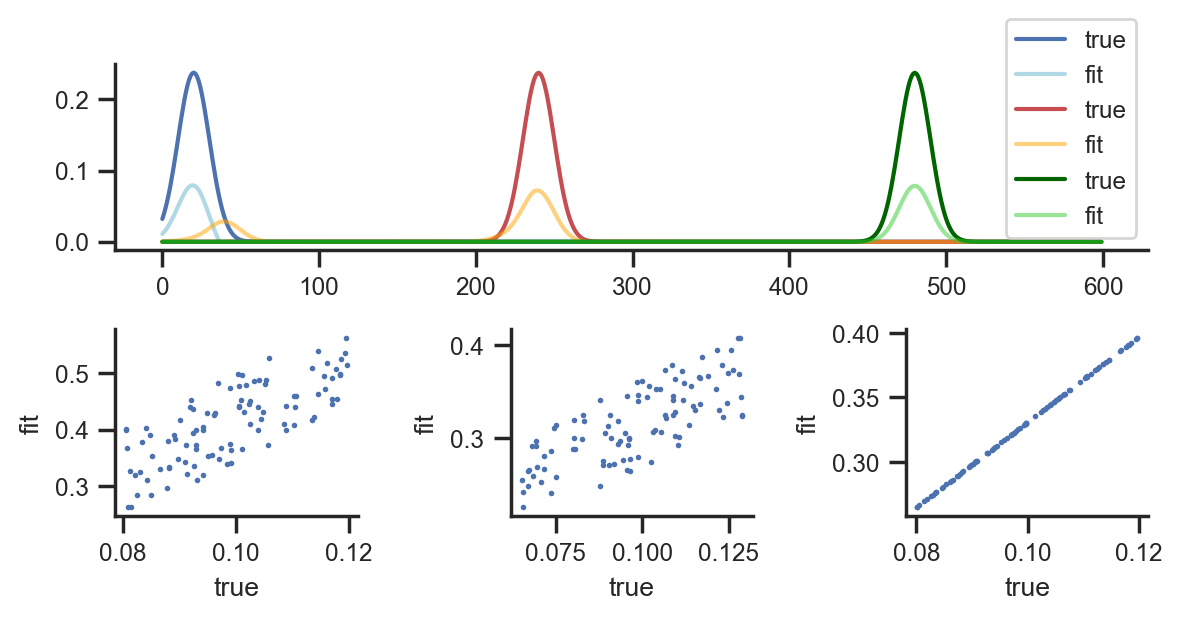

Loss: 0.5761111974716187


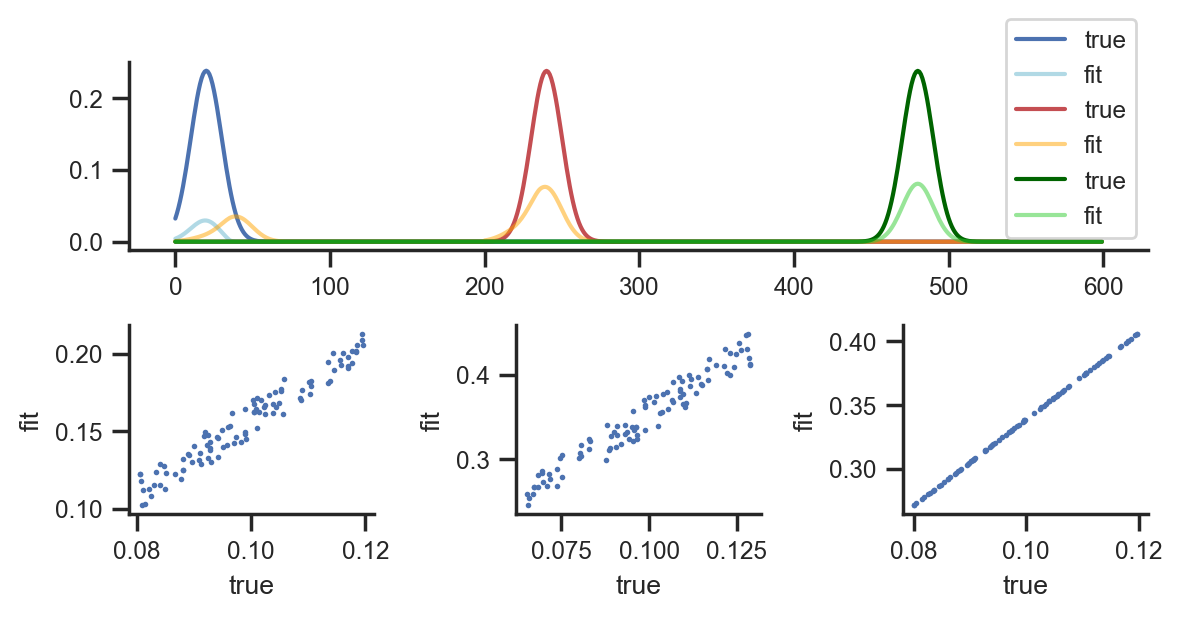

Loss: 0.7725178599357605


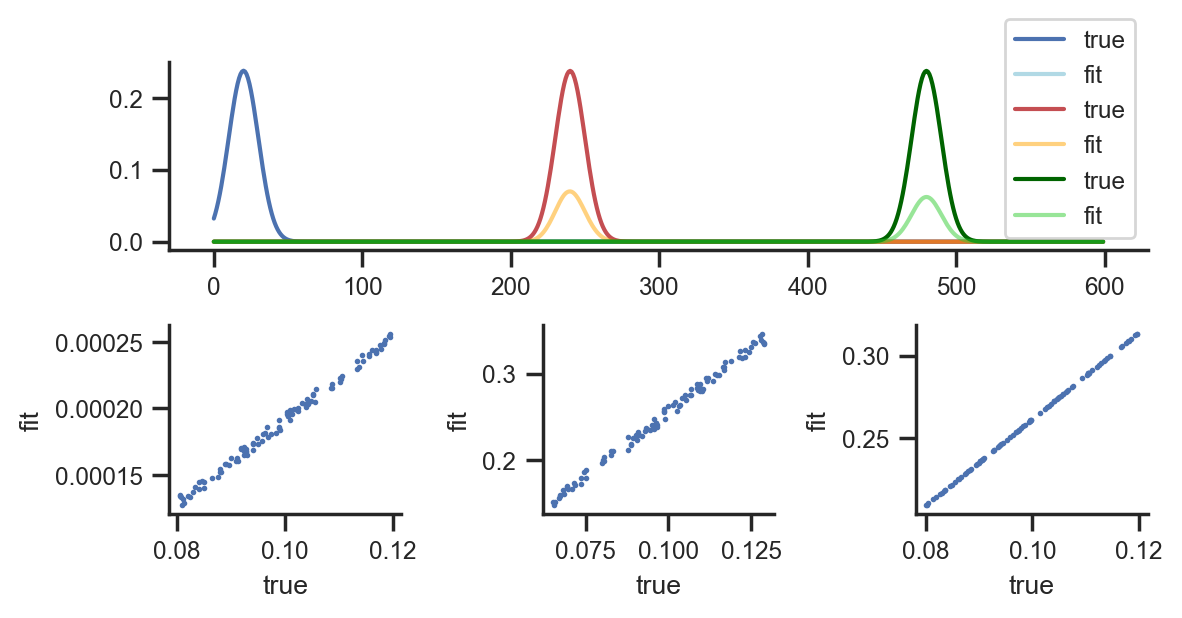

Loss: 1.0773491859436035


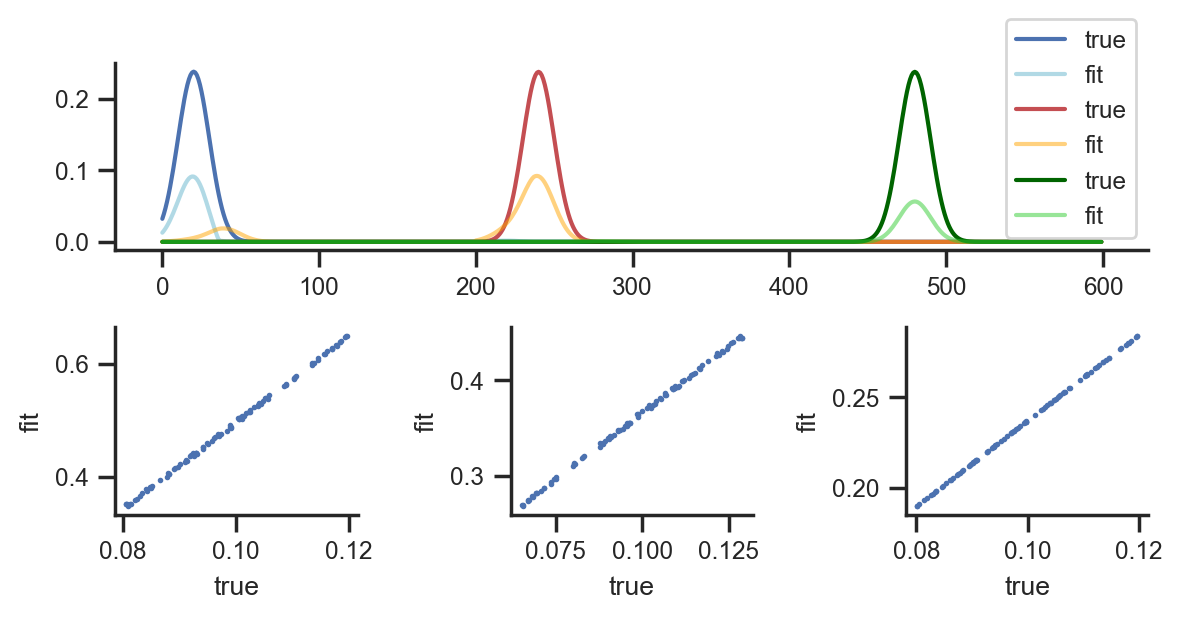

Loss: 1.1932893991470337


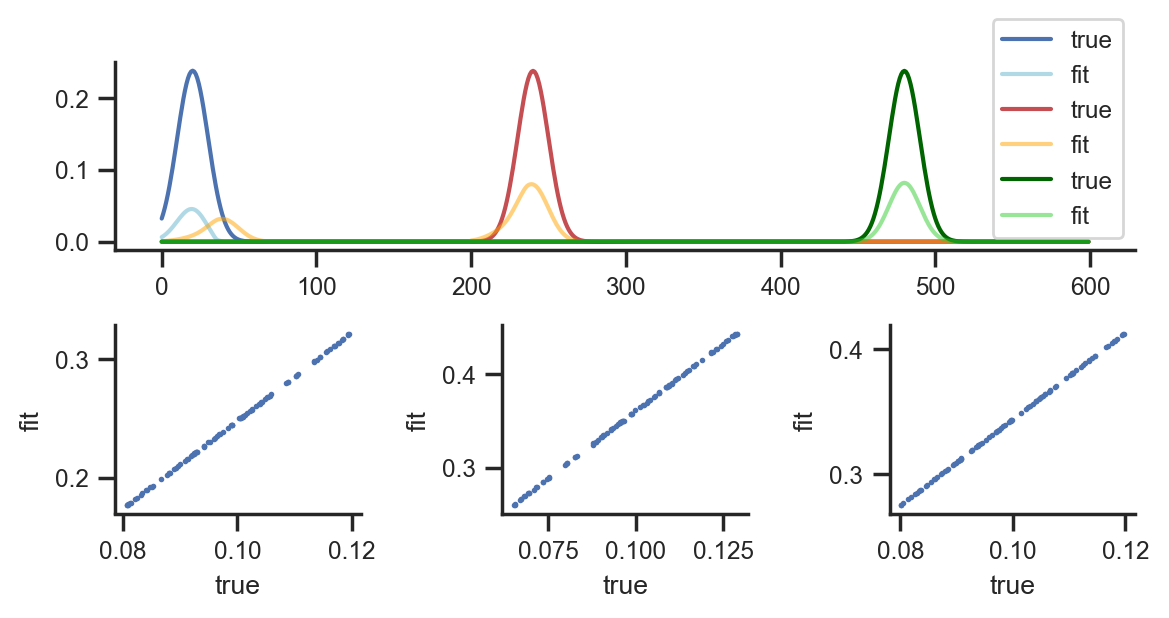

Loss: 0.6118413209915161


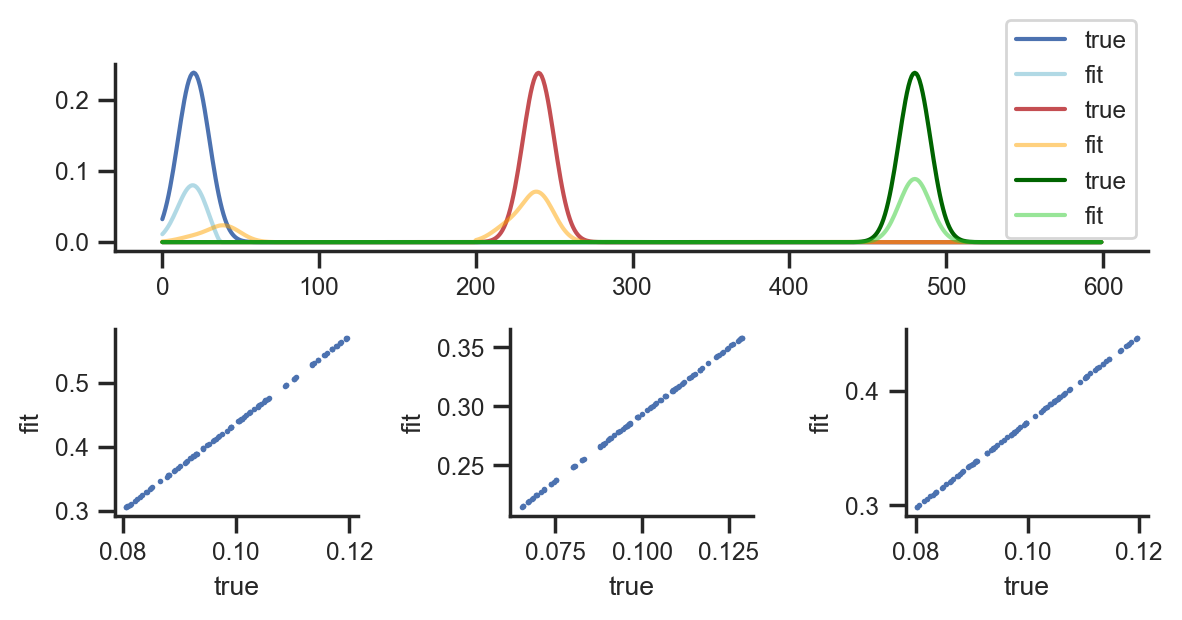

Loss: 0.7589437961578369


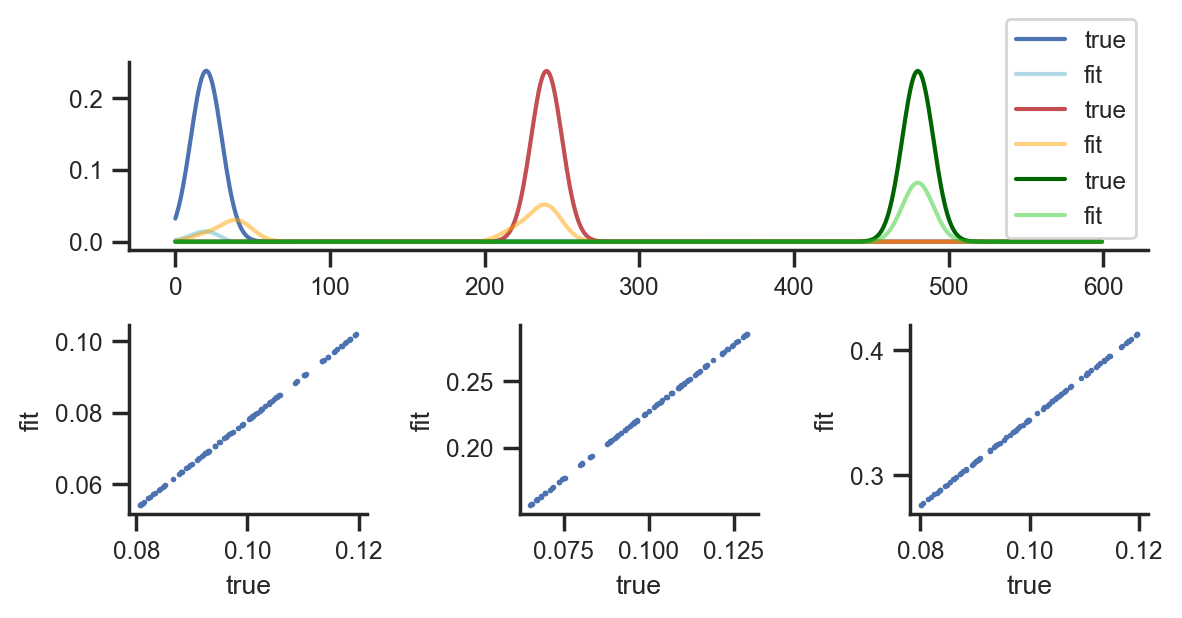

Loss: 0.9701029658317566


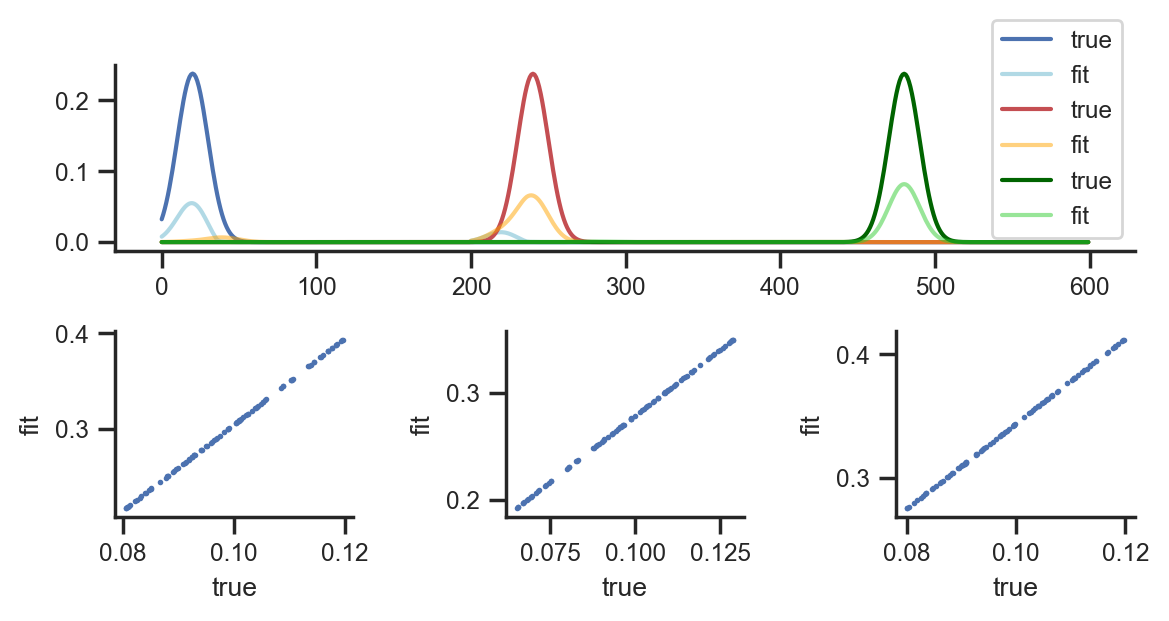

Loss: 0.49748364090919495


In [5]:
# Set learning rate
lr = .1

# post gradient step modifiers:
min_value = 1e-4
prox_plus = torch.nn.Threshold(0, min_value)
prox_softplus = torch.nn.Softplus()
def prox_norm(x):
    return (x / torch.norm(x, p=2))

for i in range(40000):
    #Concatenate the two tensors to create the input matrix
    a_init_ = torch.cat((a_coef[0]*a_init, a_coef[1]*a_init, a_coef[2]*a_init), dim=0)
    b_init_ = torch.cat((b_coef[0]*b_init, b_coef[1]*b_init, b_coef[2]*b_init), dim=0)
    c_init_ = torch.cat((c_coef[0]*c_init, c_coef[1]*c_init, c_coef[2]*c_init), dim=0)
    
    A_init = torch.stack((a_init_, b_init_, c_init_), dim=0).T

    ha_init = h_coef[0] * h_init_ab + h_bias[0]
    hb_init = prox_plus(h_coef[1] * (1-h_init_ab) + h_bias[1])
    hc_init = h_coef[2] * h_init_c

    H_init = torch.cat((ha_init, hb_init, hc_init), dim=0)

    X_ = torch.matmul(A_init, H_init)
    dmat = X_ - torch.as_tensor(X, dtype=torch.float32)
    loss = torch.linalg.matrix_norm(dmat, ord='fro')
    loss.backward(retain_graph=True)

    with torch.no_grad():
        for p in [a_init, b_init, c_init,
                  a_coef, b_coef, c_coef,
                  h_init_ab, h_init_c, h_coef, h_bias]:
            p -= lr * p.grad
            p.grad.zero_()
            p.data = prox_plus(p)
            
            
        # setting scale through normalization of A and H
        for p in [a_init, b_init, c_init]:
            p.data = prox_norm(p)

        h_init_ab.data = (h_init_ab / torch.norm(h_init_c, p=2)) * (h_init_ab.shape[1])**0.5
        h_init_c.data = (h_init_c / torch.norm(h_init_c, p=2)) * (h_init_c.shape[1])**0.5

    if i % 4000 == 0:

        # Create a grid of 2 rows and 3 columns
        gs = gridspec.GridSpec(2, 3, figure=plt.figure(figsize=(6, 3)))

        ax1 = plt.subplot(gs[0, :])  # This plot spans all columns of the first row
        ax1.plot(a_col_, c='b', label='true')
        ax1.plot(a_init_.detach().numpy(), alpha=0.5,  c='c', label='fit')
        ax1.plot(b_col_, c='r', label='true')
        ax1.plot(b_init_.detach().numpy(), c='orange', alpha=0.5, label='fit')
        ax1.plot(c_col_, c='darkgreen', label='true')
        ax1.plot(c_init_.detach().numpy(),c='limegreen', alpha=0.5, label='fit')
        ax1.legend()

        ax2 = plt.subplot(gs[1, 0])  # first column of the second row
        ax2.scatter(H[0, :], H_init[0, :].detach().numpy(), s=1, label='true')
        ax2.set(xlabel='true', ylabel='fit')

        ax3 = plt.subplot(gs[1, 1])  # second column of the second row
        ax3.scatter(H[1, :], H_init[1, :].detach().numpy(), s=1, label='true')
        ax3.set(xlabel='true', ylabel='fit')

        ax4 = plt.subplot(gs[1, 2])  # third column of the second row
        ax4.scatter(H[2, :], H_init[2, :].detach().numpy(), s=1, label='true')
        ax4.set(xlabel='true', ylabel='fit')

        plt.tight_layout()
        plt.show()

        print(f'Loss: {loss.item()}')

In [ ]:
print(b_coef.detach().numpy())

In [ ]:
x = h_init_ab.detach().numpy()
f, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(x.ravel())

print('h_coef: ', h_coef)
print('h_bias: ', h_bias)

In [ ]:
hh = H_init.detach().numpy()

f, ax = plt.subplots(3, 1, figsize=(8,4))
ax[0].plot(set_norm(H[0, :], axis=0, c=1)[0], c='b', label='true 1')
ax[0].plot(0.02+set_norm(hh[0, :], axis=0, c=1)[0], c='c', label='fit 1')
ax[0].legend()
ax[1].plot(set_norm(H[1, :], axis=0, c=1)[0], c='r', label='true 2')
ax[1].plot(0.02+set_norm(hh[1, :], axis=0, c=1)[0], c='orange', label='fit 2')
ax[1].legend()
ax[2].plot(set_norm(H[2, :], axis=0, c=1)[0], c='darkgreen', label='true 3')
ax[2].plot(0.02+set_norm(hh[2, :], axis=0, c=1)[0], c='limegreen', label='fit 3')
ax[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
print('h_coef: ',h_coef)
print('h_bias: ',h_bias)

In [6]:
# the 1-x component is tricky, particularly if it has the same weight ('a') as the x component. It introduces a degeneracy that cannot easily be resolved. 
# We'll consider 2 slightly simpler cases:
# 1. (easier) x and 1-x have different weights (mean of the gaussian of b_col is different )
# 2. (harder) x and 1-x have the same col, but their relative ratios in different channels are quite different. 

# Failure mode:
# Flexibility is first used to fit the higher variance components. 
# For example if the (1-x) component has higher variance, it will be fit with parameters that are free and not constrained to be 1-xhat.

# Variance in each channel should be ekpt the same
# This approach works for well-separated cases, where each channel has a clear signal
# When signals bleed across channels, the fitting is less reliable. 